# Fermionic Sinkhorn

Install `bfsinkhorn` if necessary

In [ ]:
%pip install git+https://github.com/DerkKooi/bfsinkhorn

In [1]:
#Toggle saving the figures
save = True

#Numerical tolerance on NOONs for removing them from the calculation
ncut = 10**-12

#Try to import bfsinkhorn, if it's not installed, try to import it from the cloned directory
try:
    import bfsinkhorn
except ModuleNotFoundError:
    import sys
    sys.path.append('..')
    import bfsinkhorn

#Import numpy
import numpy as np

#Import jax and set floats to 64-bit
from jax.config import config
import jax.numpy as jnp
config.update("jax_enable_x64", True)

#Import the Fermionic Sinkhorn
from bfsinkhorn.fermion import Sinkhorn

#Import for plotting and making plots look good
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline
plt.style.use(['seaborn-paper', 'seaborn-dark-palette'])
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('font', family='sans-serif')
plt.rc('lines', markersize=8)
single_column = 3 + 3/8

/var/folders/m3/1440kr6n0mz0kqlrfbszmzk00000gn/T/ipykernel_44481/520929450.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-paper', 'seaborn-dark-palette'])
/var/folders/m3/1440kr6n0mz0kqlrfbszmzk00000gn/T/ipykernel_44481/520929450.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-paper', 'seaborn-dark-palette'])


# Figure 3: synthetic fermion distribution

Construct a fermionic distribution of occupation numbers, with $N$ heavily occupied NOs and the remaining weakly occupied. The decay is linear in the index of the occupation number.


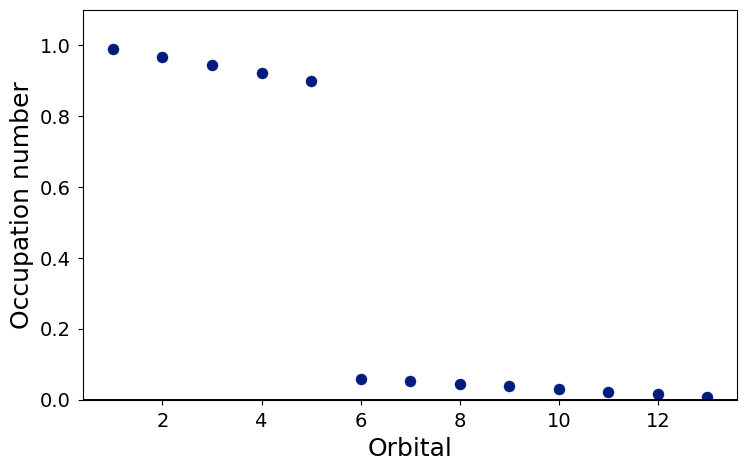

In [2]:
norb = 13
N = 5
n1 = 0.99
nN = 0.9
delta = 0.84
nlast = ((-2 + delta + n1)*N + (-delta + nN)*norb)/(N - norb)
beta = 1.
if nlast < 0.:
    print('last n is below zero')
n = np.empty(norb)
n[:N] = n1 - (n1-nN)/(N-1)*np.arange(N)
sum_to_N = np.sum(n[:N])
n[N:] = nN - delta + np.arange(norb-N)*(N*(2 - 2*delta - n1 + nN) + 2*(delta - nN)*norb)/((N - norb)*(1 + N - norb))
    
plt.figure(figsize=(2.5*single_column, 2*single_column*3/4))
plt.scatter(np.arange(norb)+1, n)
plt.xlabel('Orbital')
plt.ylabel('Occupation number')
plt.ylim(0, 1.1)
plt.axhline(y=0, color='0', linestyle='-')
plt.show()

Run both the fermionic and regular ('old') Sinkhorn.

In [3]:
solver = Sinkhorn(N)
solver_old = Sinkhorn(N, old=True)

print('Running Fermionic Sinkhorn')
result = solver.run_sinkhorn_fixed_iters(n, n_iters=100)
print('Running regular Sinkhorn')
result_old = solver_old.run_sinkhorn_fixed_iters(n, n_iters=100)

Running Fermionic Sinkhorn
Running regular Sinkhorn


Fermionic Sinkhorn first lingers behind Sinkhorn, but then converges well. Make a nice plot to show this. 

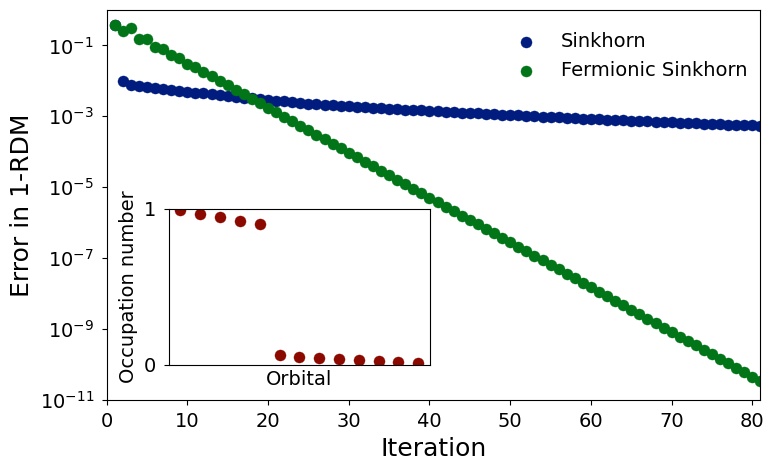

In [4]:
single_column = 3 + 3/8

fig = plt.figure(figsize=(2.5*single_column, 2*single_column*3/4))

plt.yscale('log')
plt.scatter(np.arange(len(result_old['n_error']))+1, result_old['n_error'], label='Sinkhorn')
plt.scatter(np.arange(len(result['n_error']))+1, result['n_error'], label='Fermionic Sinkhorn')
plt.legend(loc=(0.6, 0.8), framealpha=0)
plt.xlabel('Iteration')
plt.ylabel('Error in 1-RDM')
plt.ylim(10**-11, 1)
plt.xlim(0, 81)
ax = fig.get_axes()[0]
axins = inset_axes(ax, width="40%", height="40%", loc=3, bbox_to_anchor=(0.08,0.065,1,1), bbox_transform=ax.transAxes)
plt.scatter(np.arange(norb)+1, n, color='C2')
plt.xlabel('Orbital', fontsize=SMALL_SIZE)
plt.ylabel('Occupation number', fontsize=SMALL_SIZE)
plt.xticks([])
plt.yticks([0, 1])
plt.ylim(0, 1)
plt.savefig('fig3_fermion_convergence.pdf',
            bbox_inches='tight', 
            transparent=True,
            pad_inches=0.1)
plt.show()

# Supplementary figure 3: hotstart Fermionic Sinkhorn

Show what happens if we start instead from a Sinkhorn starting point run for 10 iterations.

Running Fermionic Sinkhorn with hotstart
Running Sinkhorn


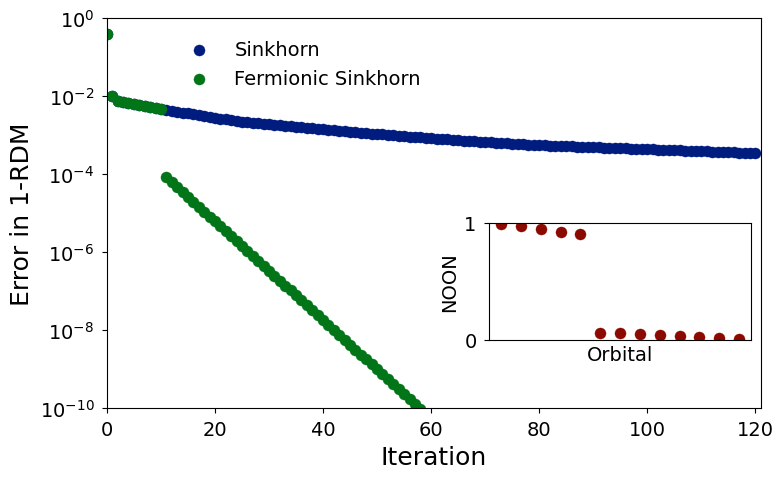

In [5]:
solver = Sinkhorn(N, hotstart=10)
solver_old = Sinkhorn(N, old=True)
n_iters = 120

print('Running Fermionic Sinkhorn with hotstart')
result = solver.run_sinkhorn_fixed_iters(n, n_iters=n_iters)
print('Running Sinkhorn')
result_old = solver_old.run_sinkhorn_fixed_iters(n, n_iters=n_iters)


fig = plt.figure(figsize=(2.5*single_column, 2*single_column*3/4))

plt.yscale('log')
plt.scatter(np.arange(len(result_old['n_error'])), result_old['n_error'], label='Sinkhorn')
plt.scatter(np.arange(len(result['n_error'])), result['n_error'], label='Fermionic Sinkhorn')
plt.legend(loc=(0.1, 0.8), framealpha=0)
plt.xlabel('Iteration')
plt.ylabel('Error in 1-RDM')
plt.ylim(10**-10, 1)
plt.xlim(0, n_iters+1)
ax = fig.get_axes()[0]
axins = inset_axes(ax, width="40%", height="30%", loc=3, bbox_to_anchor=(0.57,0.15,1,1), bbox_transform=ax.transAxes)
plt.scatter(np.arange(norb)+1, n, color='C2')
plt.xlabel('Orbital', fontsize=SMALL_SIZE)
plt.ylabel('NOON', fontsize=SMALL_SIZE)
plt.xticks([])
plt.yticks([0, 1])
plt.ylim(0, 1)
if save:
    plt.savefig('Sfig3_fermion_convergence_hotstart.pdf',
                bbox_inches='tight', 
                transparent=True,
                pad_inches=0.1)
plt.show()

Now switch to modelling zero-temperature occupation numbers with a non-interacting canonical ensemble. We use `pyscf` for the ground-state calculations.

In [6]:
from pyscf import gto, scf, cc

# Figure 4: H<sub>2</sub>O at equilibrium geometry
First run a CCSD calculation in a cc-pVQZ basis.

In [7]:
mol = gto.M(atom='''O 0.0000000 0.0000000 0.1172700; 
H 0.0000000 0.7569520 -0.4690790;
H 0.0000000 -0.7569520 -0.4690790''', basis='cc-pVQZ')
mf = scf.RHF(mol)
mf.kernel()
ccsd = cc.CCSD(mf).run()

converged SCF energy = -76.0648123417998
E(CCSD) = -76.38183505216404  E_corr = -0.3170227103642183


In [8]:
n_iters = 500
n, U = jnp.linalg.eigh(ccsd.make_rdm1())
N = sum(mol.nelec)//2
n = jnp.flip(n)/2
n = n[np.where(n > ncut)]
n = n/np.sum(n)*N

solver = Sinkhorn(N, hotstart=10)
solver_old = Sinkhorn(N, old=True)

norb = n.size
result = solver.run_sinkhorn_fixed_iters(n, n_iters=n_iters)
result_old = solver_old.run_sinkhorn_fixed_iters(n, n_iters=n_iters)

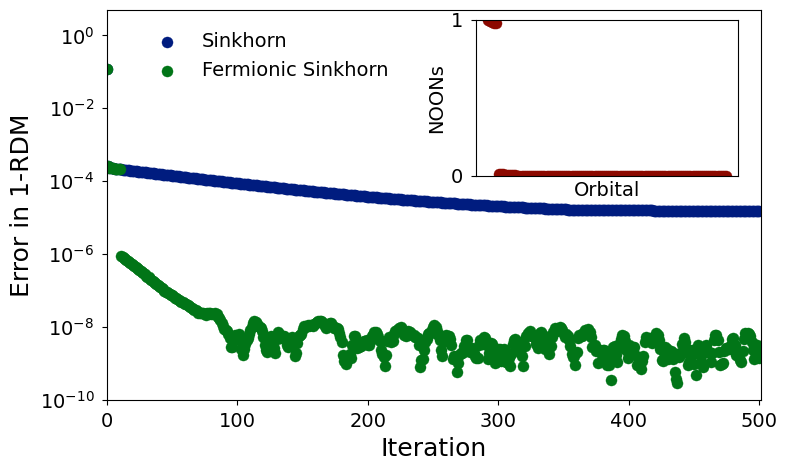

In [9]:
single_column = 3 + 3/8

fig = plt.figure(figsize=(2.5*single_column, 2*single_column*3/4))

plt.yscale('log')
plt.scatter(np.arange(len(result_old['n_error'])), result_old['n_error'], label='Sinkhorn')
plt.scatter(np.arange(len(result['n_error'])), result['n_error'], label='Fermionic Sinkhorn')

plt.legend(loc=(0.05, 0.8), framealpha=0)
plt.xlabel('Iteration')
plt.ylabel('Error in 1-RDM')
plt.ylim(10**-10, 5)
plt.xlim(0, n_iters+1)
ax = fig.get_axes()[0]
axins = inset_axes(ax, width="40%", height="40%", loc=3, bbox_to_anchor=(0.55,0.55,1,1), bbox_transform=ax.transAxes)
plt.scatter(np.arange(norb)+1, n, color='C2')
plt.xlabel('Orbital', fontsize=SMALL_SIZE)
plt.ylabel('NOONs', fontsize=SMALL_SIZE)
plt.xticks([])
plt.yticks([0, 1])
plt.ylim(0, 1)
plt.savefig('fig4_H2O_convergence.pdf',
             bbox_inches='tight', 
             transparent=True,
             pad_inches=0.1)
plt.show()